In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This model uses data from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

In [11]:
from ucimlrepo import fetch_ucirepo

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
print(f"\nVariable Information:\n{diabetes_130_us_hospitals_for_years_1999_2008.variables}")

/opt/anaconda3/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)



Variable Information:
                        name     role         type demographic  \
0               encounter_id       ID                     None   
1                patient_nbr       ID                     None   
2                       race  Feature  Categorical        Race   
3                     gender  Feature  Categorical      Gender   
4                        age  Feature  Categorical         Age   
5                     weight  Feature  Categorical        None   
6          admission_type_id  Feature  Categorical        None   
7   discharge_disposition_id  Feature  Categorical        None   
8        admission_source_id  Feature  Categorical        None   
9           time_in_hospital  Feature      Integer        None   
10                payer_code  Feature  Categorical        None   
11         medical_specialty  Feature  Categorical        None   
12        num_lab_procedures  Feature      Integer        None   
13            num_procedures  Feature      Integer   

In [3]:
data = pd.read_csv("diabetes_data/diabetic_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In total there are 101766 entries but only 71518 patients. Need to stratify split training and testing by patient ID (patient_nbr column)
### Part 1: Exploratory Data Analysis
Examine numerical and categorical columns separately

In [15]:
diabetes_130_us_hospitals_for_years_1999_2008.variables.columns

Index(['name', 'role', 'type', 'demographic', 'description', 'units',
       'missing_values'],
      dtype='object')

In [33]:
# separate numerical and categorical columns
features_info = diabetes_130_us_hospitals_for_years_1999_2008.variables
num_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Integer")]
cat_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Categorical")]
print(f"Numerical Columns:\n{num_cols}")
print(f"Categorical Columns:\n{cat_cols}")

Numerical Columns:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical Columns:
['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


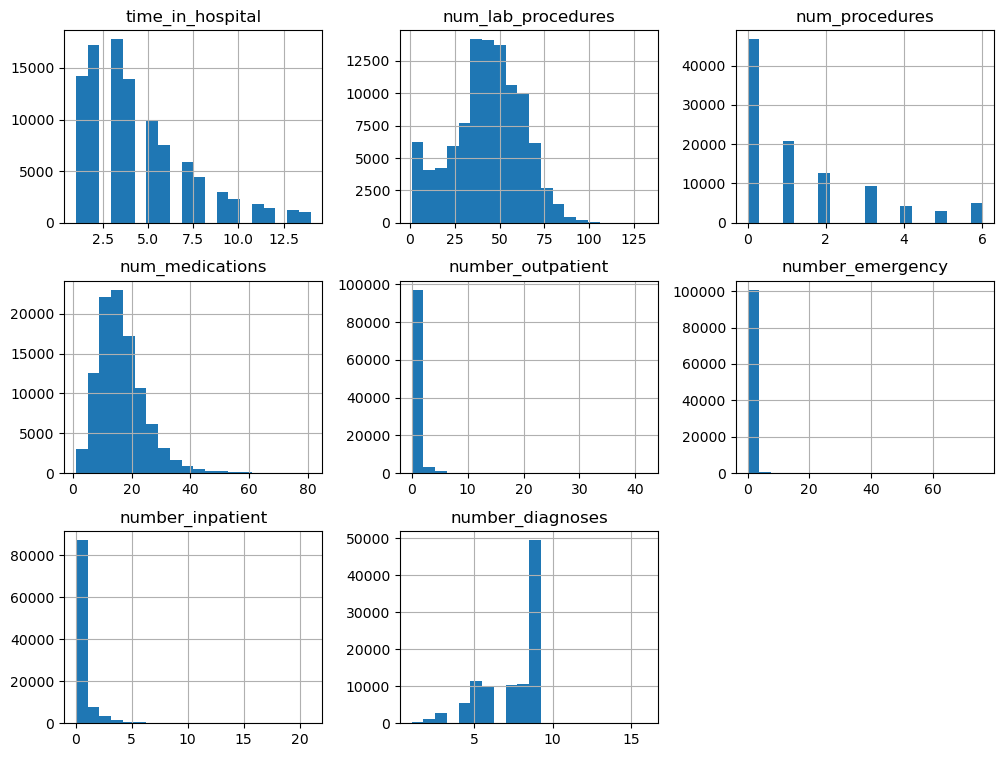

In [56]:
# graph histograms of numerical data
data[num_cols].hist(bins = 20, figsize = (12, 9))
plt.show()